# 04. Calibration & Credit Scoring

## Mục tiêu
- Hiệu chỉnh (calibration) Probability of Default (PD)
- Đảm bảo PD có ý nghĩa xác suất
- Chuyển PD ∈ [0,1] → Credit Score (1–10)

Lưu ý quan trọng:
- KHÔNG dự đoán score trực tiếp
- Credit Score được xây dựng **sau calibration**
- Quy trình phù hợp chuẩn nghiên cứu & thực tiễn tín dụng

In [1]:
# MountDrive & setup
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = "/content/drive/MyDrive/NCKH"
DATA_PROCESSED = f"{PROJECT_ROOT}/data/processed"
MODELS_DIR = f"{PROJECT_ROOT}/models"
SRC_DIR = f"{PROJECT_ROOT}/src"

import os, sys
sys.path.append(SRC_DIR)

print("Environment ready")


Mounted at /content/drive
Environment ready


## Load dữ liệu và mô hình đã huấn luyện

Sử dụng:
- Dữ liệu đã gán nhãn từ Notebook 02
- Mô hình PD tốt nhất từ Notebook 03

In [2]:
import pandas as pd
import numpy as np
from joblib import load

from config import FEATURE_COLUMNS, TARGET_COLUMN, ExperimentConfig
from scoring import calibrate_model, eval_pd, pd_to_score

cfg = ExperimentConfig()

df = pd.read_csv(f"{DATA_PROCESSED}/data_labeled.csv")

# Load best model
import os
from joblib import load

ARTIFACT_DIR = f"{MODELS_DIR}/artifacts"

model_files = [
    f for f in os.listdir(ARTIFACT_DIR)
    if f.endswith(".joblib")
]

assert len(model_files) == 1, f"Expected exactly 1 model, found {model_files}"

model_path = f"{ARTIFACT_DIR}/{model_files[0]}"
base_model = load(model_path)

model_files[0]


'LightGBM.joblib'

## Tách tập train/test theo thời gian (như Modeling)

Calibration chỉ dùng dữ liệu TRAIN để tránh leakage.

In [3]:
from features import add_features

# Feature engineering (PHẢI CÓ)
df_feat = add_features(df, missing_flag_cols=cfg.MISSING_FLAG_COLS)

# Time-based split trên df_feat
train_df = df_feat[df_feat["year"] <= cfg.TRAIN_YEAR].copy()
test_df  = df_feat[df_feat["year"] == cfg.TEST_YEAR].copy()

X_train = train_df[FEATURE_COLUMNS]
y_train = train_df[TARGET_COLUMN]

X_test = test_df[FEATURE_COLUMNS]
y_test = test_df[TARGET_COLUMN]

train_df.shape, test_df.shape

X_train = train_df[FEATURE_COLUMNS]
y_train = train_df[TARGET_COLUMN]

X_test = test_df[FEATURE_COLUMNS]
y_test = test_df[TARGET_COLUMN]

train_df.shape, test_df.shape

((228, 41), (225, 41))

## Calibration Probability of Default (PD)

Lý do cần calibration:
- Mô hình ML thường dự đoán xác suất bị lệch
- Credit scoring yêu cầu PD phản ánh xác suất thực
- Chuẩn mực trong nghiên cứu và ngân hàng

Phương pháp:
- Isotonic Regression (phi tham số, linh hoạt)

In [4]:
# Isotonic Calibration – Cross-validated
calibrated_model = calibrate_model(
    base_model,
    X_train=X_train,
    y_train=y_train,
    method="isotonic",
    n_splits=5
)

[LightGBM] [Info] Number of positive: 70, number of negative: 112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 961
[LightGBM] [Info] Number of data points in the train set: 182, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 70, number of negative: 112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 962
[LightGBM] [Info] Number of data points in the train set: 182, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 70, number of negative: 112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 960
[LightGBM] [Info] Number of data points in the train set: 182, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Đánh giá PD sau calibration

So sánh:
- Trước calibration
- Sau calibration

Chỉ số:
- ROC-AUC
- Brier Score (độ chính xác xác suất)

In [5]:
metrics_cal, pd_hat = eval_pd(
    calibrated_model,
    X_test=X_test,
    y_test=y_test
)

metrics_cal

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,0
ROC_AUC,0.995885
PR_AUC,0.993054
Brier,0.026409


## Phân phối PD sau calibration

Kiểm tra:
- PD nằm trong [0,1]
- Không bị co cụm bất thường

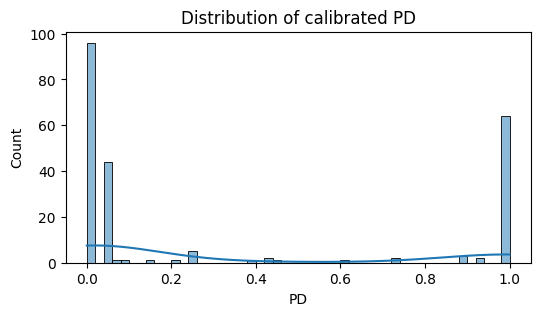

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,3))
sns.histplot(pd_hat, bins=50, kde=True)
plt.title("Distribution of calibrated PD")
plt.xlabel("PD")
plt.show()

## Chuyển PD → Credit Score (1–10)

Nguyên tắc:
- PD thấp → Score cao
- PD cao → Score thấp
- Chia theo decile (quantile-based scoring)

Đây là cách phổ biến trong thực tế khi không có scorecard chuẩn.

In [7]:
df_test = test_df.copy()
df_test["PD"] = pd_hat
df_test["credit_score"] = pd_to_score(df_test["PD"], bins=10)

df_test[["PD","credit_score"]].head()

,PD,credit_score
1,0.000000,10
3,0.000000,10
5,0.424709,4
7,0.000000,10
9,0.040000,6


## Kiểm tra tính đơn điệu (Monotonicity)

PD trung bình phải:
- Tăng dần khi score giảm
- Giảm dần khi score tăng

In [8]:
monotonic_check = (
    df_test.groupby("credit_score")["PD"]
    .mean()
    .sort_index(ascending=False)
)

monotonic_check

,PD
credit_score,
10,0.000000
9,0.000000
8,0.000000
7,0.000000
6,0.029946
5,0.043674
4,0.302328
3,0.982056
2,1.000000


## Phân phối Credit Score

Kiểm tra:
- Không quá lệch
- Có đủ quan sát ở các mức score

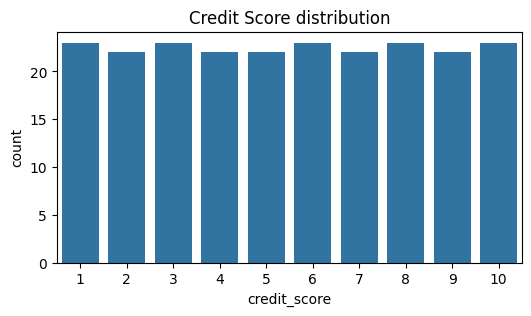

In [9]:
plt.figure(figsize=(6,3))
sns.countplot(x="credit_score", data=df_test)
plt.title("Credit Score distribution")
plt.show()

## Lưu kết quả scoring

Kết quả này sẽ được dùng cho:
- Explainability (Notebook 05)
- Segment analysis (Notebook 06)

In [10]:
output_path = f"{DATA_PROCESSED}/scored_test_data.csv"
df_test.to_csv(output_path, index=False)

print("Saved:", output_path)

Saved: /content/drive/MyDrive/NCKH/data/processed/scored_test_data.csv


## Tổng kết Notebook 04

Notebook này đã:
- Hiệu chỉnh PD bằng Isotonic Regression
- Đảm bảo PD có ý nghĩa xác suất
- Chuyển PD → Credit Score (1–10)
- Kiểm tra monotonicity và phân phối score

Đây là bước trung tâm của đề tài nghiên cứu.